
## How to Use the Notebooks

To run these notebooks, follow these steps:


### 1. Install **`gdal`** Package
Installing `gdal` via `pip` may fail. Therefore, we recommend using conda to install it:
```bash
conda install gdal -c conda-forge
```

### 2. Install **`polsartools`** Package

Before running the notebooks, you'll need to install the core **`polsartools`** package. 

**Option A:** Install from PyPI `pip` (stable release)

```bash
pip install polsartools
```

**Option B:** Install from conda (stable release)

```bash
conda install polsartools -c bnarayanarao
```


**Option C:**  Install the latest version from GitHub (if you need recent updates or fixes)

```bash
pip install git+https://github.com/Narayana-Rao/polsartools.git#egg=polsartools
```
> **Note:** If you encounter a `"module not found"` error or require newer features, prefer the **Option C**.

### 3. Verify the Installation

After successfully installing `polsartools`, you can verify it by importing the package:

```bash
import polsartools as pst
```

If this runs without errors, you're ready to explore and run the notebooks.




In [1]:
import polsartools as pst
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np


In [2]:
""" 

Function to display images

"""

def plot_images(*filenames, lower_percentile=2, upper_percentile=98, max_cols=4):
    def compute_vmin_vmax(data):
        data_no_nan = data[np.isfinite(data)]
        vmin = np.percentile(data_no_nan, lower_percentile)
        vmax = np.percentile(data_no_nan, upper_percentile)
        return vmin, vmax

    num_images = len(filenames)

    if num_images == 1:
        # Single image case
        data = pst.read_rst(filenames[0])
        data[data==0]=np.nan
        vmin, vmax = compute_vmin_vmax(data)

        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(data, vmin=vmin, vmax=vmax)
        ax.set_title(os.path.basename(filenames[0]))
        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()
    else:
        # Multiple image case
        ncols = min(max_cols, num_images)
        nrows = int(np.ceil(num_images / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
        axes = np.array(axes).reshape(-1)  # Flatten in case it's a 2D grid

        for i, filename in enumerate(filenames):
            data = pst.read_rst(filename)
            data[data==0]=np.nan
            vmin, vmax = compute_vmin_vmax(data)
            ax = axes[i]
            im = ax.imshow(data, vmin=vmin, vmax=vmax)
            ax.set_title(os.path.basename(filename))
            fig.colorbar(im, ax=ax)

        for j in range(num_images, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()


#### 1. Extract single look S2 or multilooked T3/C3 matrix elements
ASAR data can be downloaded from [https://uavsar.jpl.nasa.gov/cgi-bin/asar-data.pl](https://uavsar.jpl.nasa.gov/cgi-bin/asar-data.pl)

The sample a dataset used in this tutorial can be downloaded from the following URLs

http://downloaduav.jpl.nasa.gov/Release2s/Rosamd_1702N_A2102_003_210630/V1.3.B/L/ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5

http://downloaduav.jpl.nasa.gov/Release2s/Rosamd_1702N_A2102_003_210630/V1.3.B/S/ASAR_S_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5

In [ ]:
# Provide path to the extracted folder

inFile = r"../data/ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5"

#The follwoing function extracts single look S2 or mulit-looked T3/C3 matrix from ISRO's ASAR Full Pol data
pst.isro_asar(inFile,mat='C3',azlks=22,rglks=10) # for a multi-look factor of 2.16


Detected L-band ['VV' 'VH' 'HV' 'HH'] 
Extracting C3 matrix elements...



Processing chunks:   0%|          | 0/490 [00:00<?, ?it/s]


Processing chunks:   0%|          | 1/490 [00:04<34:16,  4.21s/it]


Processing chunks:   2%|▏         | 8/490 [00:04<03:14,  2.48it/s]


Processing chunks:   2%|▏         | 12/490 [00:04<01:56,  4.11it/s]


Processing chunks:   3%|▎         | 15/490 [00:04<01:29,  5.32it/s]


Processing chunks:   6%|▌         | 28/490 [00:04<00:32, 14.18it/s]


Processing chunks:   7%|▋         | 34/490 [00:05<00:32, 14.16it/s]


Processing chunks:   9%|▉         | 44/490 [00:05<00:23, 18.68it/s]


Processing chunks:  10%|▉         | 48/490 [00:05<00:22, 19.36it/s]


Processing chunks:  12%|█▏        | 59/490 [00:05<00:17, 24.78it/s]


Processing chunks:  13%|█▎        | 63/490 [00:06<00:18, 22.81it/s]


Processing chunks:  15%|█▌        | 74/490 [00:06<00:12, 33.04it/s]


Processing chunks:  16%|█▌        | 79/490 [00:06<00:17, 23.26it/s]


Processing chunks:  19%|█▉        | 92/490 [00:07<00:13, 28.96it/s]


Processing chunks:  20%|█▉        | 96/490 [00:07<00:15, 25.88it/s]


Processing chunks:  22%|██▏       | 107/490 [00:07<00:10, 35.02it/s]


Processing chunks:  23%|██▎       | 112/490 [00:07<00:14, 26.54it/s]


Processing chunks:  24%|██▎       | 116/490 [00:08<00:14, 25.97it/s]


Processing chunks:  25%|██▌       | 124/490 [00:08<00:13, 26.76it/s]


Processing chunks:  26%|██▌       | 128/490 [00:08<00:15, 23.38it/s]


Processing chunks:  29%|██▉       | 141/490 [00:08<00:12, 27.20it/s]


Processing chunks:  29%|██▉       | 144/490 [00:09<00:13, 24.78it/s]


Processing chunks:  30%|███       | 148/490 [00:09<00:13, 25.79it/s]


Processing chunks:  32%|███▏      | 156/490 [00:09<00:10, 31.64it/s]


Processing chunks:  33%|███▎      | 160/490 [00:09<00:11, 30.00it/s]


Processing chunks:  33%|███▎      | 164/490 [00:09<00:13, 24.43it/s]


Processing chunks:  35%|███▍      | 171/490 [00:09<00:10, 31.75it/s]


Processing chunks:  36%|███▌      | 176/490 [00:10<00:10, 28.59it/s]


Processing chunks:  37%|███▋      | 180/490 [00:10<00:11, 26.57it/s]


Processing chunks:  38%|███▊      | 184/490 [00:10<00:10, 28.15it/s]


Processing chunks:  39%|███▉      | 190/490 [00:10<00:08, 33.88it/s]


Processing chunks:  40%|███▉      | 194/490 [00:10<00:11, 25.42it/s]


Processing chunks:  40%|████      | 198/490 [00:11<00:13, 22.06it/s]


Processing chunks:  42%|████▏     | 208/490 [00:11<00:09, 29.70it/s]


Processing chunks:  43%|████▎     | 212/490 [00:11<00:12, 22.77it/s]


Processing chunks:  44%|████▍     | 215/490 [00:11<00:11, 23.83it/s]


Processing chunks:  46%|████▌     | 225/490 [00:12<00:09, 29.36it/s]


Processing chunks:  47%|████▋     | 229/490 [00:12<00:09, 26.98it/s]


Processing chunks:  47%|████▋     | 232/490 [00:12<00:11, 22.46it/s]


Processing chunks:  49%|████▉     | 242/490 [00:12<00:08, 28.82it/s]


Processing chunks:  50%|█████     | 246/490 [00:12<00:09, 26.15it/s]


Processing chunks:  51%|█████     | 249/490 [00:12<00:09, 25.92it/s]


Processing chunks:  52%|█████▏    | 253/490 [00:13<00:08, 27.87it/s]


Processing chunks:  53%|█████▎    | 260/490 [00:13<00:07, 30.41it/s]


Processing chunks:  54%|█████▍    | 264/490 [00:13<00:08, 26.86it/s]


Processing chunks:  54%|█████▍    | 267/490 [00:13<00:08, 27.36it/s]


Processing chunks:  56%|█████▌    | 274/490 [00:13<00:06, 32.45it/s]


Processing chunks:  57%|█████▋    | 278/490 [00:13<00:07, 27.25it/s]


Processing chunks:  57%|█████▋    | 281/490 [00:14<00:08, 25.89it/s]


Processing chunks:  59%|█████▉    | 288/490 [00:14<00:05, 34.18it/s]


Processing chunks:  60%|█████▉    | 292/490 [00:14<00:06, 32.62it/s]


Processing chunks:  60%|██████    | 296/490 [00:14<00:08, 23.99it/s]


Processing chunks:  62%|██████▏   | 304/490 [00:14<00:05, 34.23it/s]


Processing chunks:  63%|██████▎   | 309/490 [00:14<00:05, 31.43it/s]


Processing chunks:  64%|██████▍   | 313/490 [00:15<00:06, 26.12it/s]


Processing chunks:  65%|██████▍   | 317/490 [00:15<00:06, 24.95it/s]


Processing chunks:  66%|██████▋   | 325/490 [00:15<00:06, 26.06it/s]


Processing chunks:  67%|██████▋   | 330/490 [00:15<00:06, 26.30it/s]


Processing chunks:  69%|██████▉   | 337/490 [00:15<00:04, 31.18it/s]


Processing chunks:  70%|██████▉   | 341/490 [00:16<00:05, 28.53it/s]


Processing chunks:  70%|███████   | 345/490 [00:16<00:05, 26.67it/s]


Processing chunks:  72%|███████▏  | 351/490 [00:16<00:04, 28.45it/s]


Processing chunks:  73%|███████▎  | 358/490 [00:16<00:04, 28.28it/s]


Processing chunks:  74%|███████▍  | 365/490 [00:17<00:04, 28.16it/s]


Processing chunks:  76%|███████▌  | 372/490 [00:17<00:03, 32.45it/s]


Processing chunks:  77%|███████▋  | 376/490 [00:17<00:03, 32.25it/s]


Processing chunks:  78%|███████▊  | 380/490 [00:17<00:03, 27.91it/s]


Processing chunks:  79%|███████▉  | 386/490 [00:17<00:03, 30.11it/s]


Processing chunks:  80%|████████  | 393/490 [00:17<00:03, 29.91it/s]


Processing chunks:  81%|████████  | 397/490 [00:18<00:03, 30.54it/s]


Processing chunks:  82%|████████▏ | 401/490 [00:18<00:03, 28.63it/s]


Processing chunks:  83%|████████▎ | 407/490 [00:18<00:02, 28.93it/s]


Processing chunks:  84%|████████▍ | 414/490 [00:18<00:02, 27.08it/s]


Processing chunks:  86%|████████▌ | 421/490 [00:18<00:02, 27.52it/s]


Processing chunks:  87%|████████▋ | 428/490 [00:19<00:01, 31.38it/s]


Processing chunks:  88%|████████▊ | 432/490 [00:19<00:01, 30.32it/s]


Processing chunks:  89%|████████▉ | 436/490 [00:19<00:01, 29.47it/s]


Processing chunks:  90%|█████████ | 443/490 [00:19<00:01, 37.15it/s]


Processing chunks:  91%|█████████▏| 448/490 [00:19<00:01, 30.92it/s]


Processing chunks:  92%|█████████▏| 452/490 [00:19<00:01, 30.07it/s]


Processing chunks:  94%|█████████▎| 459/490 [00:20<00:01, 29.29it/s]


Processing chunks:  95%|█████████▌| 466/490 [00:20<00:00, 34.63it/s]


Processing chunks:  97%|█████████▋| 474/490 [00:20<00:00, 36.07it/s]


Processing chunks:  98%|█████████▊| 478/490 [00:20<00:00, 34.87it/s]


Processing chunks:  99%|█████████▉| 484/490 [00:20<00:00, 39.57it/s]


Processing chunks: 100%|██████████| 490/490 [00:20<00:00, 23.64it/s]

Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C11.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C12_real.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C12_imag.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C13_real.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C13_imag.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C22.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C23_real.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C23_imag.tif


Saved file ..\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\C3\C33.tif


Execution time for isro_asar: 01:07 (min:sec)


#### 2. Speckle filtering using polarimetric refined-Lee filter

In [4]:
"""
The following function generates speckle filtered polarimetric matrices using the refined Lee polarimetric speckle filter: 
        
input C3/T3/C2/T2 folder path, window_size

"""

C3Folder = os.path.join(inFile.split('.h5')[0],'C3')
window_size = 3
pst.rlee(C3Folder,win=window_size)


Progress:   0%|          | 0/4 [00:00<?, ?block/s]


Progress:  25%|██▌       | 1/4 [00:04<00:13,  4.51s/block]


Progress:  50%|█████     | 2/4 [00:05<00:04,  2.42s/block]


Progress: 100%|██████████| 4/4 [00:05<00:00,  1.07block/s]


Progress: 100%|██████████| 4/4 [00:05<00:00,  1.39s/block]

Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C11.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C12_real.tif


Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C12_imag.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C13_real.tif


Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C13_imag.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C22.tif


Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C23_real.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C23_imag.tif


Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\C33.tif
Execution time for rlee: 7.00 seconds


#### 3. Generate a quick look Pauli RGB from C3/T3 matrix

Pauli RGB image saved as ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\PauliRGB.png
Execution time for pauliRGB: 0.00 seconds


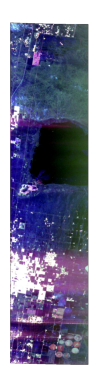

In [5]:
# update the C3 folder based on your folder
C3Folder = os.path.join(inFile.split('.h5')[0],f"rlee_{window_size}x{window_size}",'C3')
# r'.\ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3'

pst.pauliRGB(C3Folder)

#### 4. Generating Decomposition parameters

#### 4.1. Generate H/A/α Decomposition parameters


Progress:   0%|          | 0/4 [00:00<?, ?block/s]


Progress:  25%|██▌       | 1/4 [00:06<00:19,  6.44s/block]


Progress:  50%|█████     | 2/4 [00:12<00:12,  6.09s/block]


Progress:  75%|███████▌  | 3/4 [00:12<00:03,  3.49s/block]


Progress: 100%|██████████| 4/4 [00:12<00:00,  2.19s/block]


Progress: 100%|██████████| 4/4 [00:12<00:00,  3.22s/block]

Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\H_fp.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\alpha_fp.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\anisotropy_fp.tif


Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\e1_norm.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\e2_norm.tif
Saved file ../ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B\rlee_3x3\C3\e3_norm.tif
Execution time for halpha_fp: 13.00 seconds


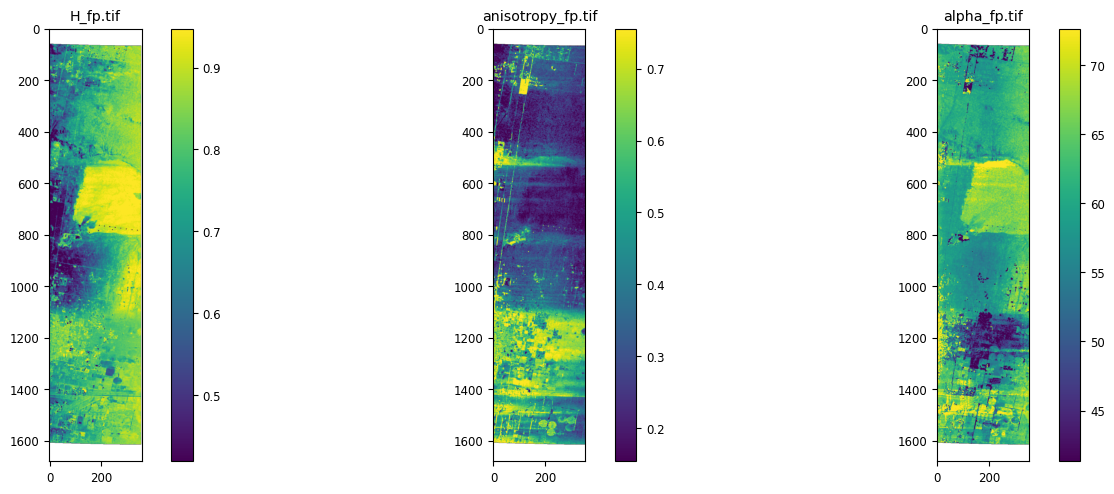

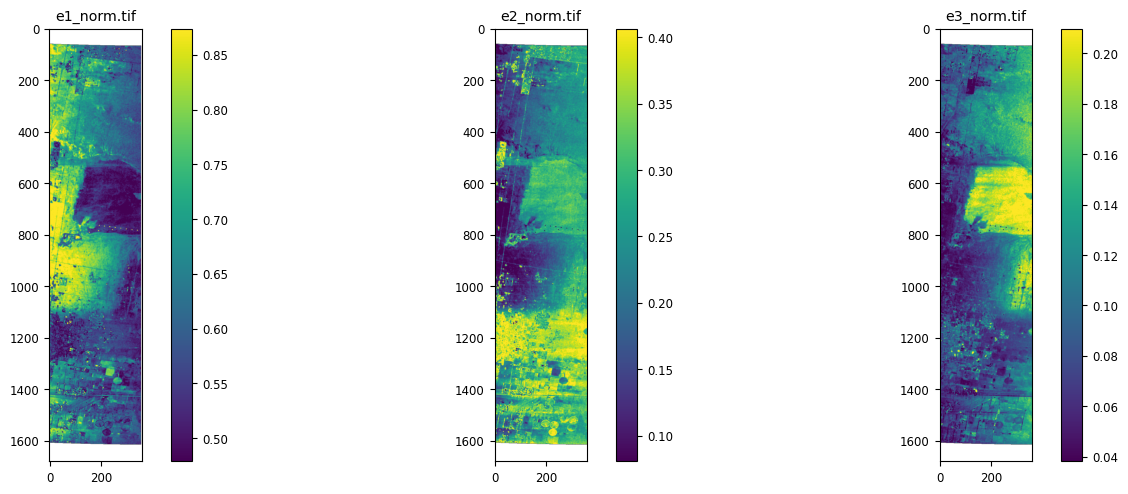

In [6]:

"""
The following function generates H/A/alpha demposition paramters: 
        Alpha, entropy, anisotropy and 
        normalized eigen values e1_norm, e2_norm, e3_norm in geotif format

input C3/T3 folder path, window_size is optional  

"""
# update the C3 folder based on your folder
# C3Folder = '._rlee_3x3\C3'

pst.halpha_fp(C3Folder,win=3) 


### Plotting
plot_images(os.path.join(C3Folder,'H_fp.tif'),
             os.path.join(C3Folder,'anisotropy_fp.tif'),
              os.path.join(C3Folder,'alpha_fp.tif'))

plot_images(os.path.join(C3Folder,'e1_norm.tif'),
             os.path.join(C3Folder,'e2_norm.tif'),
             os.path.join(C3Folder,'e3_norm.tif'))




#### Plot Entropy-Alpha 2D plane

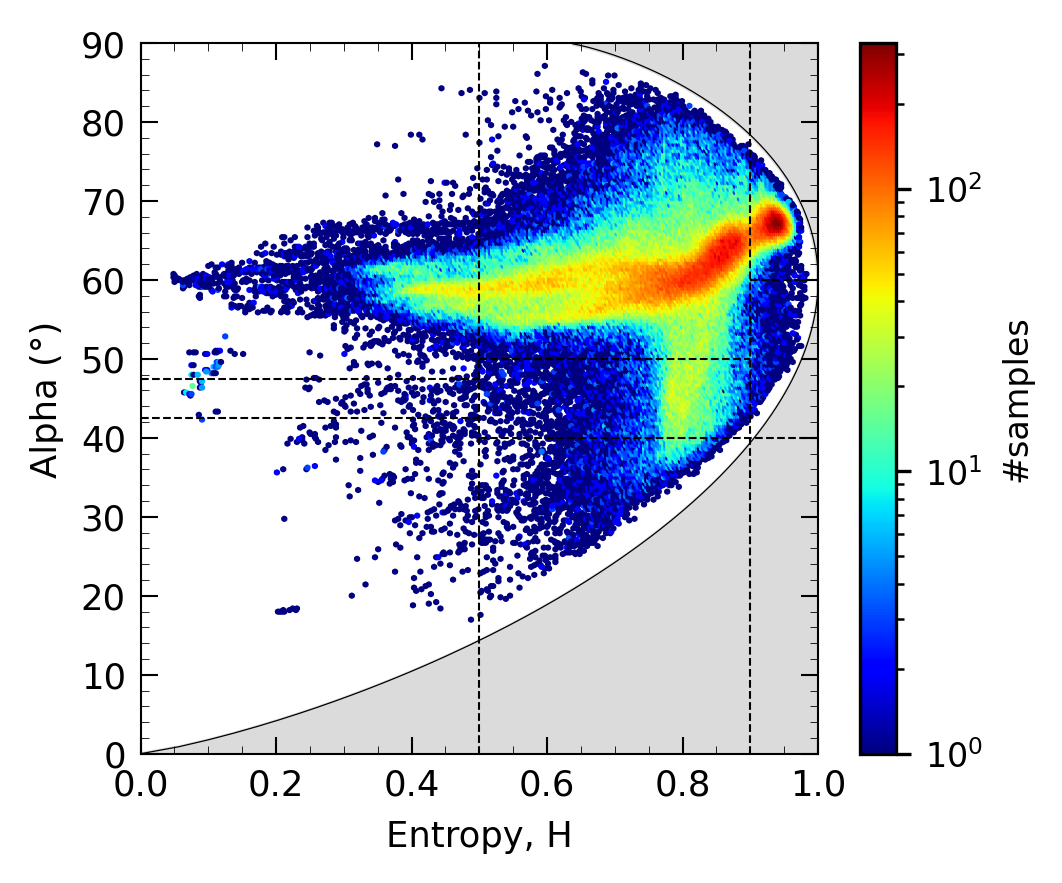

In [7]:
hFile = C3Folder + '/H_fp.tif'
alphaFile = C3Folder + '/alpha_fp.tif'

pst.halpha_plot_fp(hFile,alphaFile,cmap='jet',               
                   norm='log',
                   # path = '',# give a name.png to save the plot as png 
                  zone_lines=True,
                  zone_ids=False,)

#### Plot a 3D Entropy-Anisotropy-Alpha plot

Execution time for haalpha_plot_fp: 5.00 seconds


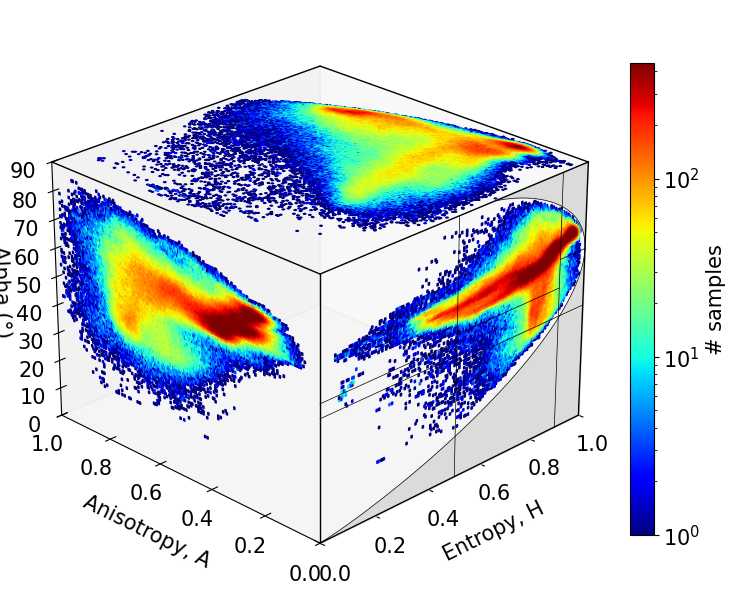

In [8]:
hFile = C3Folder + '/H_fp.tif'
aFile = C3Folder + '/anisotropy_fp.tif'
alphaFile = C3Folder + '/alpha_fp.tif'

pst.haalpha_plot_fp(hFile,aFile,alphaFile,cmap='jet',               
                   norm='log',
                   # path = '',# give a name.png to save the plot as png 
                  zone_lines=True,
                  # zone_ids=False,
                   )